# Loading libraries

In [1]:
!git clone https://github.com/dml-qom/FarsTail

Cloning into 'FarsTail'...
remote: Enumerating objects: 125, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 125 (delta 19), reused 18 (delta 18), pack-reused 104
Receiving objects: 100% (125/125), 43.86 MiB | 12.75 MiB/s, done.
Resolving deltas: 100% (33/33), done.


In [2]:
!pip install transformers
!pip install hazm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 73.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 48.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 477.8/477.8 kB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 93.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.5/993.5 kB 82.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency confl

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.utils import shuffle

import hazm
#from cleantext import clean

import plotly.express as px
import plotly.graph_objects as go

from tqdm.notebook import tqdm

import os
import re
import json
import copy
import collections
import re
from hazm import Normalizer, word_tokenize,Stemmer
from hazm import stopwords_list, word_tokenize
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
import os
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
from transformers import AutoConfig, AutoTokenizer, AutoModel
import random

# Classes and Functions

In [2]:
def preprocess(data):
  normalizer = Normalizer()
  stemmer = PorterStemmer()
  for i in range(len(data)):
    text=data[i]
    tokens = word_tokenize(text)
    filtered_tokens = [token for token in tokens if token not in stopwords_list()]
    filtered_text = ' '.join(filtered_tokens)  
    filtered_text = filtered_text.replace("\u200c", "")
    data[i]=normalizer.normalize(filtered_text)
  return data

In [3]:

def predict(testloader,model):
  all_predictions = []
  all_targets = []
  with torch.no_grad():
    loop_val = tqdm(enumerate(testloader, 1),total=len(testloader),
                    desc="val",position=0,leave=True,)
    for batch, dl in loop_val:
      ids=dl['ids']
      token_type_ids=dl['token_type_ids']
      mask= dl['mask']
      labels=dl['target']

      ids=ids.to(device)
      token_type_ids=token_type_ids.to(device)
      mask=mask.to(device)
      labels=labels.to(device)

      labels_pred=model(
          ids=ids,
          mask=mask,
          token_type_ids=token_type_ids)
      _, predicted = torch.max(labels_pred, 1)

      # Append predicted labels and true labels to the lists
      all_predictions.extend(predicted.tolist())
      all_targets.extend(labels.tolist())
  return all_predictions,all_targets

In [4]:
def plot_performance(history,name="Model"):
  figure, axis = plt.subplots(1, 2,figsize=(15,10))
  figure.suptitle('{} performance'.format(name), fontsize=16)
  axis[0].plot(history['epochs'],history['val_loss'])
  axis[0].plot(history['epochs'],history['train_loss'])
  axis[0].set_xticks(range(epochs))
  axis[0].set_xlabel("Epochs")
  axis[0].set_ylabel("Accuracy")
  axis[0].set_title("Loss")
  axis[1].plot(history['epochs'],history['val_acc'])
  axis[1].plot(history['epochs'],history['train_acc'])
  axis[1].set_xlabel("Epochs")
  axis[1].set_ylabel("Loss")
  axis[1].set_title("Accuracy")
  axis[1].set_xticks(range(epochs))
  figure.legend(["Val", "Train"], loc='upper right')
  figure.tight_layout(pad=5.0)
  return axis

In [5]:

class AverageMeter(object):
    """
    computes and stores the average and current value
    """

    def __init__(self, start_val=0, start_count=0, start_avg=0, start_sum=0):
        self.reset()
        self.val = start_val
        self.avg = start_avg
        self.sum = start_sum
        self.count = start_count

    def reset(self):
        """
        Initialize 'value', 'sum', 'count', and 'avg' with 0.
        """
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, num=1):
        """
        Update 'value', 'sum', 'count', and 'avg'.
        """
        self.val = val
        self.sum += val * num
        self.count += num
        self.avg = self.sum / self.count


def save_model(file_path, file_name, model, optimizer=None):
    """
    In this function, a model is saved.Usually save model after training in each epoch.
    ------------------------------------------------
    Args:
        - model (torch.nn.Module)
        - optimizer (torch.optim)
        - file_path (str): Path(Folder) for saving the model
        - file_name (str): name of the model checkpoint to save
    """
    state_dict = dict()
    state_dict["model"] = model.state_dict()

    if optimizer is not None:
        state_dict["optimizer"] = optimizer.state_dict()
    torch.save(state_dict, os.path.join(file_path, file_name))


def load_model(ckpt_path, model, optimizer=None):
    """
    Loading a saved model and optimizer (from checkpoint)
    """
    checkpoint = torch.load(ckpt_path, map_location=torch.device("cpu"))
    model.load_state_dict(checkpoint["model"])
    if (optimizer != None) & ("optimizer" in checkpoint.keys()):
        optimizer.load_state_dict(checkpoint["optimizer"])
    return model, optimizer


def accuracy(output, target, topk=(1,)):
    """
    Computes the accuracy over the k top predictions for the specified values of k
    """
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)
        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))
        res = []
        for k in topk:
            # correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            correct_k = correct[:k].float().sum()
            res.append(correct_k.mul_(100.0 / batch_size).item())
        return res

In [6]:
from torch.optim.lr_scheduler import StepLR
def train(train_loader,val_loader,model,epochs,learning_rate,gamma,step_size,device):

  model = model.to(device)
  history={"val_acc":[],"train_acc":[],"val_loss":[],"train_loss":[],"epochs":[]}
  # loss function
  criterion = nn.CrossEntropyLoss()

  # optimzier
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  lr_scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

  for epoch in tqdm(range(1, epochs + 1)):
    top1_acc_train = AverageMeter()
    loss_avg_train = AverageMeter()
    top1_acc_val = AverageMeter()
    loss_avg_val = AverageMeter()

    model.train()
    mode = "train"
    temp1=0
    temp2=0
    counter=0
    loop_train = tqdm(
        enumerate(train_loader, 1),
        total=len(train_loader),
        desc="train",
        position=0,
        leave=True)
    for batch, dl in loop_train:
      ids=dl['ids']
      token_type_ids=dl['token_type_ids']
      mask= dl['mask']
      labels=dl['target']

      ids=ids.to(device)
      token_type_ids=token_type_ids.to(device)
      mask=mask.to(device)
      labels=labels.to(device)

      labels_pred=model(
          ids=ids,
          mask=mask,
          token_type_ids=token_type_ids)

      loss = criterion(labels_pred, labels.squeeze())
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      acc1 = accuracy(labels_pred,labels.squeeze() )
      top1_acc_train.update(acc1[0], ids.size(0))
      loss_avg_train.update(loss.item(), ids.size(0))
      loop_train.set_description(f"Train - iteration : {epoch}")
      counter=counter+1
      temp1=temp1+loss_avg_train.avg
      temp2=temp2+top1_acc_train.avg
      loop_train.set_postfix(
          loss_batch="{:.4f}".format(loss.detach().item()),
          avg_train_loss_till_current_batch="{:.4f}".format(loss_avg_train.avg),
          top1_accuracy_train="{:.4f}".format(top1_acc_train.avg),
          max_len=2,
          refresh=True,)

    history["train_loss"].append(temp1/counter)
    history["train_acc"].append(temp2/counter)
    model.eval()
    mode = "val"
    counter=0
    temp1=0
    temp2=0
    with torch.no_grad():
      loop_val = tqdm(enumerate(val_loader, 1),total=len(val_loader),
                      desc="val",position=0,leave=True,)
      for batch, dl in loop_val:
        ids=dl['ids']
        token_type_ids=dl['token_type_ids']
        mask= dl['mask']
        labels=dl['target']

        ids=ids.to(device)
        token_type_ids=token_type_ids.to(device)
        mask=mask.to(device)
        labels=labels.to(device)

        labels_pred=model(
            ids=ids,
            mask=mask,
            token_type_ids=token_type_ids)
        loss = criterion(labels_pred, labels)
        acc1 = accuracy(labels_pred,labels )
        top1_acc_val.update(acc1[0], ids.size(0))
        loss_avg_val.update(loss.item(), ids.size(0))
        temp1=loss_avg_val.avg+temp1
        temp2=top1_acc_val.avg+temp2
        counter=counter+1
        loop_val.set_description(f"val - iteration : {epoch}")
        loop_val.set_postfix(
            loss_batch="{:.4f}".format(loss.detach().item()),
            avg_val_loss_till_current_batch="{:.4f}".format(loss_avg_val.avg),
            top1_accuracy_val="{:.4f}".format(top1_acc_val.avg),
            refresh=True,)
    history["val_loss"].append(temp1/counter)
    history["val_acc"].append(temp2/counter)
    history["epochs"].append(epoch)        
    lr_scheduler.step()
  return model, history

# Loading Data

In [7]:
train_data = pd.read_csv('/content/FarsTail/data/Train-word.csv', sep='\t')
val_data = pd.read_csv('/content/FarsTail/data/Val-word.csv', sep='\t')
test_data = pd.read_csv('/content/FarsTail/data/Test-word.csv', sep='\t')

In [8]:
train_data["premise"]=preprocess(train_data["premise"])
train_data["hypothesis"]=preprocess(train_data["hypothesis"])

test_data["premise"]=preprocess(test_data["premise"])
test_data["hypothesis"]=preprocess(test_data["hypothesis"])

val_data["premise"]=preprocess(val_data["premise"])
val_data["hypothesis"]=preprocess(val_data["hypothesis"])

<ipython-input-2-8a711b9b65bb>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[i]=normalizer.normalize(filtered_text)


# data analays and data cleaning


In [ ]:
train_data.groupby('label').count()

In [ ]:
test_data.groupby('label').count()

In [ ]:
val_data.groupby('label').count()

In [ ]:
def unique_words_seperator(column):
  words_list = list(column.str.split(' ', expand=True).stack().unique())
  # In the following line, I am removing puncuation mark from the end or beginning of the words.
  rec_words_list = [w.strip('.,;()[]') for w in words_list]
  return rec_words_list

In [ ]:
def common_words_finder(vocab1, vocab2):
  common_vocab = [word for word in vocab1 if word in vocab2] 
  return common_vocab

In [ ]:
dev_s1 = unique_words_seperator(val_data['premise'])
dev_s2 = unique_words_seperator(val_data['hypothesis'])
dev_vocab = dev_s1 + dev_s2
dev_vocab = list(set(dev_vocab))    # to only keep unique words

test_s1 = unique_words_seperator(test_data['premise'])
test_s2 = unique_words_seperator(test_data['hypothesis'])
test_vocab = test_s1 + test_s2
test_vocab = list(set(test_vocab))    # to only keep unique words

print("Number of unique words in val set: ", str(len(dev_vocab)))
print("Number of unique words in test set: ", str(len(test_vocab)))
print("Number of unique common words in val and test set: ", str(len(common_words_finder(dev_vocab, test_vocab))))
print("percentage of common words in test set: ", str(len(common_words_finder(dev_vocab, test_vocab)) / len(test_vocab)))

In [ ]:
def sentence_encoder(s, tokenizer):
  """
  This turns each sentence into a list of tokens, adds '[SEP]' token to end of the list, then turns tokens
  into ids and returns list of ids.

  INPUTS:
    s: input sentence
    tokenizer: an instance of BERT tokenizer
  
  OUTPUTS:
    (python list): list of ids of the words of input sentence 
  """
  
  tokens = list(tokenizer.tokenize(str(s)))
  tokens.append('[SEP]')
  return tokenizer.convert_tokens_to_ids(tokens)

In [ ]:
import tensorflow as tf
def bert_input_encoder(train_corpus, tokenizer):

  sentence1 = tf.ragged.constant([sentence_encoder(s, tokenizer) for s in np.array(train_corpus['premise'])])
  sentence2 = tf.ragged.constant([sentence_encoder(s, tokenizer) for s in np.array(train_corpus['hypothesis'])])
  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])] * sentence1.shape[0]
  
  input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor()

  segment_cls = tf.zeros_like(cls)
  segment_s1 = tf.zeros_like(sentence1)
  segment_s2 = tf.ones_like(sentence2)
  input_segment_ids = tf.concat([segment_cls, segment_s1, segment_s2], axis=-1).to_tensor()

  inputs_dic = {
    'input_word_ids': input_word_ids.to_tensor(),
    'input_mask': input_mask,
    'input_segment_ids': input_segment_ids,
    'labels':np.array(train_corpus['label'])
  }

  return inputs_dic

# desgining deep model

In [9]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [10]:
from torch.utils.data import Dataset
from transformers import AutoConfig, AutoTokenizer, AutoModel

class BertDataset(Dataset):
    def __init__(self, tokenizer,max_length,address):
        super(BertDataset, self).__init__()
        self.train_csv=pd.read_csv(address, sep='\t')
        self.tokenizer=tokenizer
        self.train_csv['label'] = pd.Categorical(self.train_csv['label'])
        self.train_csv['label'] = self.train_csv['label'].cat.codes
        self.labels=self.train_csv['label']
        self.target=self.train_csv.iloc[:,2]
        self.max_length=max_length
        
    def __len__(self):
        return len(self.train_csv)
    
    def __getitem__(self, index):
        
        text1 = self.train_csv.iloc[index,0]
        text2 = self.train_csv.iloc[index,1]
        inputs = self.tokenizer.encode_plus(
            text1 ,
            text2,
            pad_to_max_length=True,
            add_special_tokens=True,
            return_attention_mask=True,
            max_length=self.max_length,
        )
        ids = inputs["input_ids"]
        token_type_ids = inputs["token_type_ids"]
        mask = inputs["attention_mask"]
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'target': torch.tensor(self.labels[index], dtype=torch.long)
            }

tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")
traindataset = BertDataset(tokenizer, max_length=100,address="/content/FarsTail/data/Train-word.csv")
trainloader =DataLoader(dataset=traindataset,batch_size=32)

testdataset = BertDataset(tokenizer, max_length=100,address="/content/FarsTail/data/Test-word.csv")
testloader =DataLoader(dataset=testdataset,batch_size=32)


valdataset = BertDataset(tokenizer, max_length=100,address="/content/FarsTail/data/Val-word.csv")
valloader =DataLoader(dataset=valdataset,batch_size=32)

In [11]:
class Finetuned_bert(nn.Module):
    def __init__(self, hidden_size, num_classes,config_layer,freeze):
        super(Finetuned_bert, self).__init__()
        self.model = AutoModel.from_pretrained("HooshvareLab/bert-base-parsbert-uncased",config = config_layer)
        self.model=self.model.to(device)
        if freeze:
          for param in self.model.parameters():
            param.requires_grad = False
        self.fc1 = nn.Linear(hidden_size, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, num_classes)
    
    def forward(self,ids,mask,token_type_ids):
        _,o2= self.model(ids,attention_mask=mask,token_type_ids=token_type_ids, return_dict=False)
        o2 = self.fc1(o2)
        o2 = self.relu(o2)
        logits = self.fc2(o2)
        return logits

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config_layer = AutoConfig.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")
classifier=Finetuned_bert(768,3,config_layer,False)

Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Define your custom network
class MyNetwork(nn.Module):
    def __init__(self, config_layer,freeze, num_classes):
        super(MyNetwork, self).__init__()
        bert_model = AutoModel.from_pretrained("HooshvareLab/bert-base-parsbert-uncased",config = config_layer)
        if freeze:
          for param in bert_model.parameters():
            param.requires_grad = False
        self.embedding = bert_model
        self.transformer_layer = nn.TransformerEncoderLayer(
            d_model=bert_model.config.hidden_size,
            nhead=bert_model.config.num_attention_heads
        )
        self.transformer = nn.TransformerEncoder(
            encoder_layer=self.transformer_layer,
            num_layers=1
        )
        self.fc = nn.Linear(bert_model.config.hidden_size, num_classes)
        
    def forward(self,ids,mask,token_type_ids):
        embeddings = self.embedding(ids,mask,token_type_ids)[0]
        encoded = self.transformer(embeddings)
        pooled = encoded.mean(dim=1)  # Average pooling over the sequence length
        logits = self.fc(pooled)
        return logits

# Task 1

In [ ]:


batch_size = 64
epochs = 15
learning_rate = 0.0001
gamma=0.5
step_size=10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config_layer = AutoConfig.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")
classifier=MyNetwork(config_layer,True,3)
model,history = train(train_loader=trainloader,val_loader=valloader,model = classifier,epochs=epochs,
                learning_rate=learning_rate,gamma = gamma,step_size = step_size,device=device)


Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/15 [00:00<?, ?it/s]

train:   0%|          | 0/228 [00:00<?, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


val:   0%|          | 0/49 [00:00<?, ?it/s]

train:   0%|          | 0/228 [00:00<?, ?it/s]

val:   0%|          | 0/49 [00:00<?, ?it/s]

train:   0%|          | 0/228 [00:00<?, ?it/s]

val:   0%|          | 0/49 [00:00<?, ?it/s]

train:   0%|          | 0/228 [00:00<?, ?it/s]

val:   0%|          | 0/49 [00:00<?, ?it/s]

train:   0%|          | 0/228 [00:00<?, ?it/s]

val:   0%|          | 0/49 [00:00<?, ?it/s]

train:   0%|          | 0/228 [00:00<?, ?it/s]

val:   0%|          | 0/49 [00:00<?, ?it/s]

train:   0%|          | 0/228 [00:00<?, ?it/s]

val:   0%|          | 0/49 [00:00<?, ?it/s]

train:   0%|          | 0/228 [00:00<?, ?it/s]

val:   0%|          | 0/49 [00:00<?, ?it/s]

train:   0%|          | 0/228 [00:00<?, ?it/s]

val:   0%|          | 0/49 [00:00<?, ?it/s]

train:   0%|          | 0/228 [00:00<?, ?it/s]

val:   0%|          | 0/49 [00:00<?, ?it/s]

train:   0%|          | 0/228 [00:00<?, ?it/s]

val:   0%|          | 0/49 [00:00<?, ?it/s]

train:   0%|          | 0/228 [00:00<?, ?it/s]

val:   0%|          | 0/49 [00:00<?, ?it/s]

train:   0%|          | 0/228 [00:00<?, ?it/s]

val:   0%|          | 0/49 [00:00<?, ?it/s]

train:   0%|          | 0/228 [00:00<?, ?it/s]

val:   0%|          | 0/49 [00:00<?, ?it/s]

train:   0%|          | 0/228 [00:00<?, ?it/s]

val:   0%|          | 0/49 [00:00<?, ?it/s]

array([<Axes: title={'center': 'Loss'}, xlabel='Epochs', ylabel='Accuracy'>,
       <Axes: title={'center': 'Accuracy'}, xlabel='Epochs', ylabel='Loss'>],
      dtype=object)

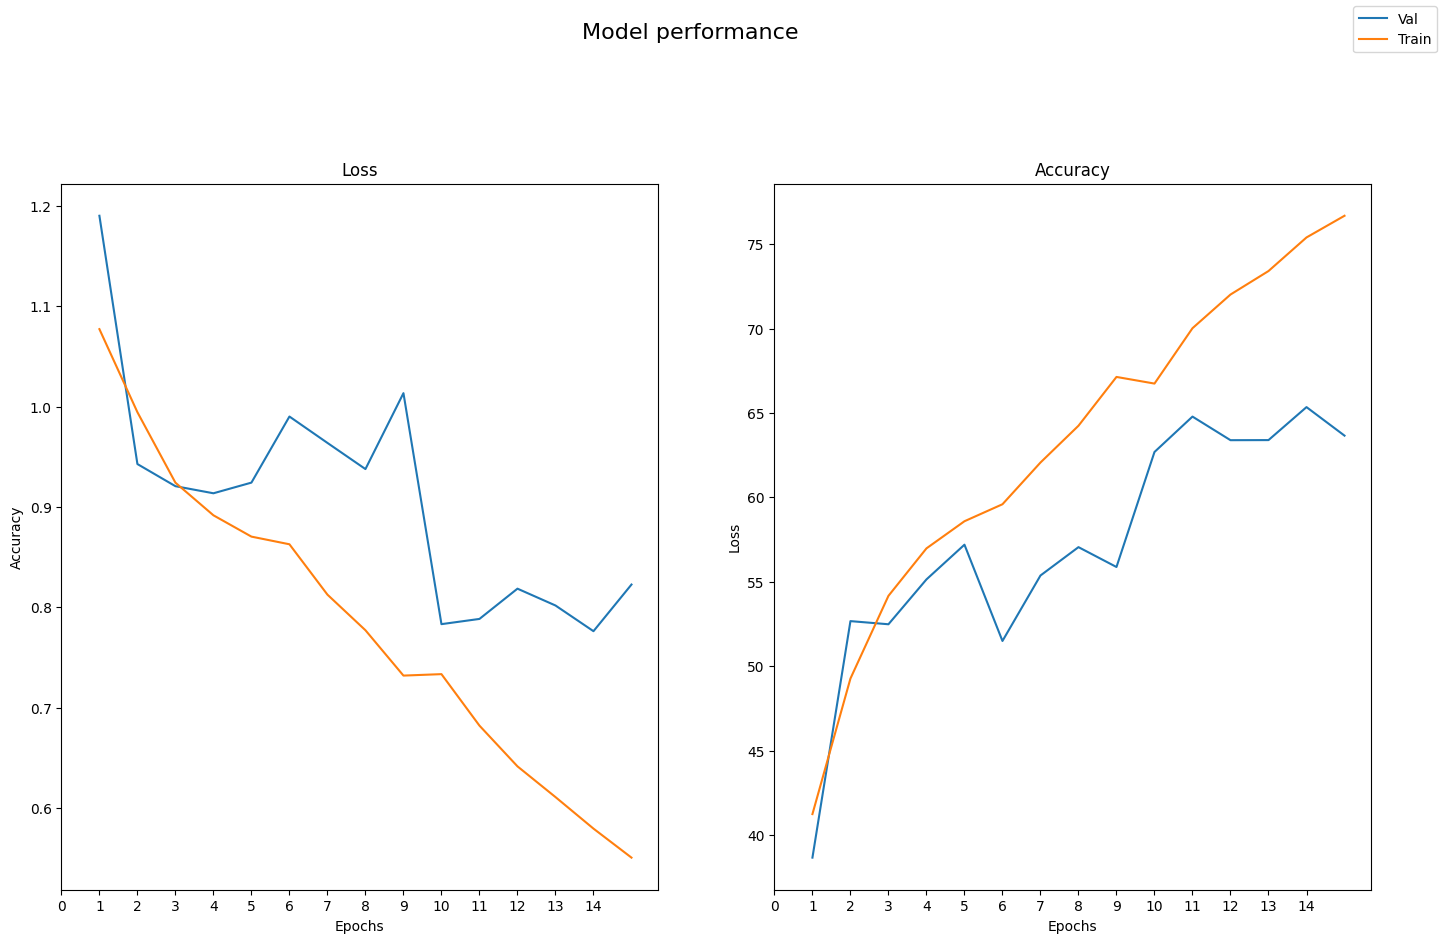

In [ ]:
plot_performance(history)

val:   0%|          | 0/228 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


val:   0%|          | 0/49 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


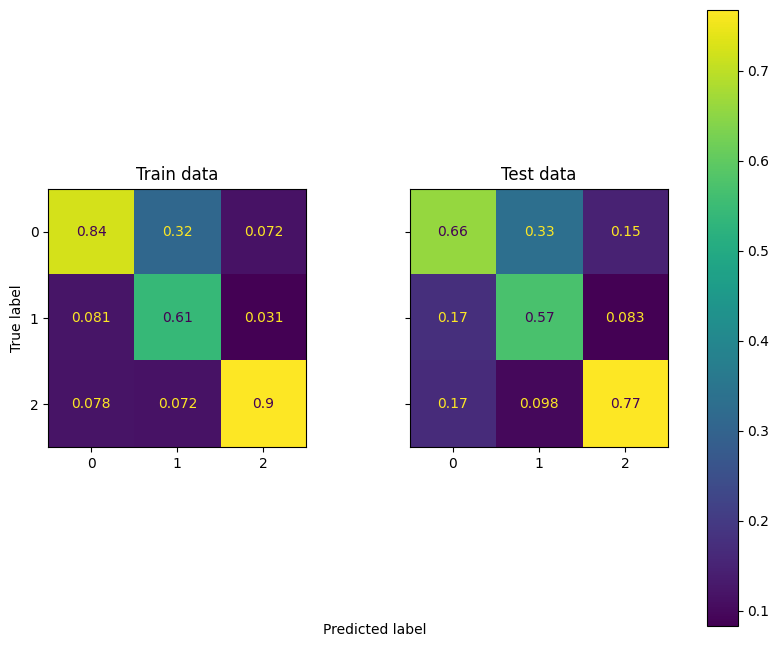

In [ ]:
from itertools import product
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
f, axarr = plt.subplots(1, 2, sharex="col", sharey="row", figsize=(10, 8))

for idx, clf, tt in zip([0,1],
    ["Train data", "Test data"],
    [trainloader,testloader] ):
    y_pred,y_test=predict(tt,model)
    result = confusion_matrix(y_test, y_pred , normalize='pred' )
    disp = ConfusionMatrixDisplay(confusion_matrix=result)
    disp.plot(ax= axarr[idx])
    disp.ax_.set_title(clf)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if idx!=0:
        disp.ax_.set_ylabel('')

f.text(0.4, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)
f.colorbar(disp.im_, ax=axarr)
plt.show()

In [ ]:
from sklearn.metrics import classification_report
all_targets, all_predictions=predict(testloader,model)
print("The model classification report on test data is as followed:")
print(classification_report(all_targets, all_predictions))

all_targets, all_predictions=predict(trainloader,model)
print("The model classification report on train data is as followed:")
print(classification_report(all_targets, all_predictions))

val:   0%|          | 0/49 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


The model classification report on test data is as followed:
              precision    recall  f1-score   support

           0       0.43      0.65      0.52       339
           1       0.73      0.64      0.68       589
           2       0.86      0.72      0.79       636

    accuracy                           0.68      1564
   macro avg       0.67      0.67      0.66      1564
weighted avg       0.72      0.68      0.69      1564



val:   0%|          | 0/228 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


The model classification report on train data is as followed:
              precision    recall  f1-score   support

           0       0.57      0.83      0.68      1657
           1       0.85      0.71      0.78      2891
           2       0.92      0.83      0.88      2718

    accuracy                           0.78      7266
   macro avg       0.78      0.79      0.78      7266
weighted avg       0.81      0.78      0.79      7266



# Task 2 

In [ ]:
batch_size = 64
epochs = 10
learning_rate = 0.0001
gamma=0.5
step_size=10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config_layer = AutoConfig.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")
classifier=Finetuned_bert(768,3,config_layer,False)
model,history = train(train_loader=trainloader,val_loader=valloader,model = classifier,epochs=epochs,
                learning_rate=learning_rate,gamma = gamma,step_size = step_size,device=device)

Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/10 [00:00<?, ?it/s]

train:   0%|          | 0/228 [00:00<?, ?it/s]

val:   0%|          | 0/49 [00:00<?, ?it/s]

train:   0%|          | 0/228 [00:00<?, ?it/s]

val:   0%|          | 0/49 [00:00<?, ?it/s]

train:   0%|          | 0/228 [00:00<?, ?it/s]

val:   0%|          | 0/49 [00:00<?, ?it/s]

train:   0%|          | 0/228 [00:00<?, ?it/s]

val:   0%|          | 0/49 [00:00<?, ?it/s]

train:   0%|          | 0/228 [00:00<?, ?it/s]

val:   0%|          | 0/49 [00:00<?, ?it/s]

train:   0%|          | 0/228 [00:00<?, ?it/s]

val:   0%|          | 0/49 [00:00<?, ?it/s]

train:   0%|          | 0/228 [00:00<?, ?it/s]

val:   0%|          | 0/49 [00:00<?, ?it/s]

train:   0%|          | 0/228 [00:00<?, ?it/s]

val:   0%|          | 0/49 [00:00<?, ?it/s]

train:   0%|          | 0/228 [00:00<?, ?it/s]

val:   0%|          | 0/49 [00:00<?, ?it/s]

train:   0%|          | 0/228 [00:00<?, ?it/s]

val:   0%|          | 0/49 [00:00<?, ?it/s]

array([<Axes: title={'center': 'Loss'}, xlabel='Epochs', ylabel='Accuracy'>,
       <Axes: title={'center': 'Accuracy'}, xlabel='Epochs', ylabel='Loss'>],
      dtype=object)

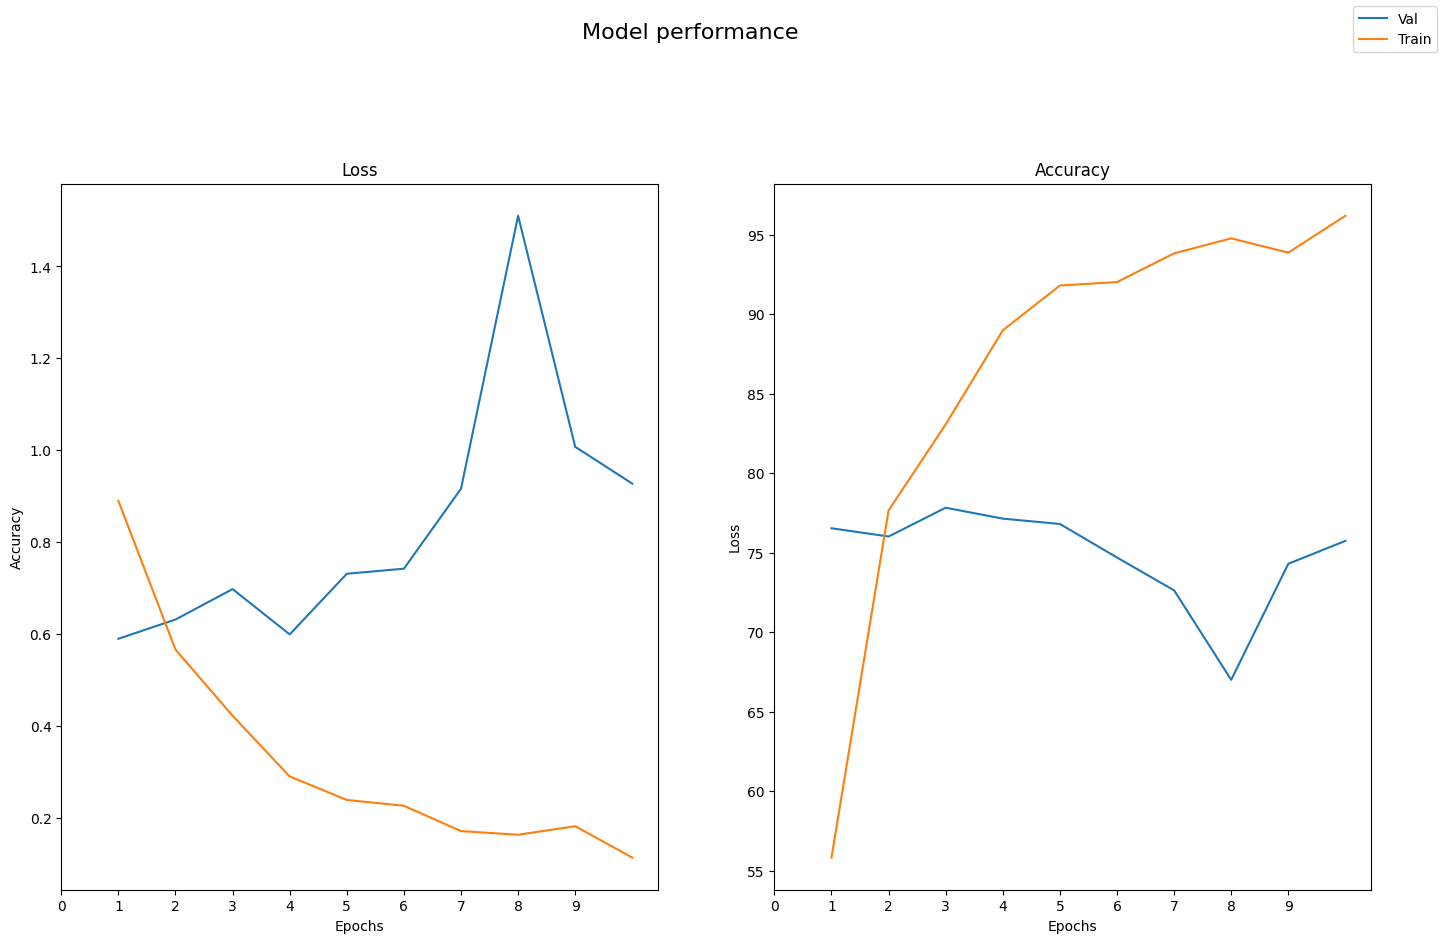

In [ ]:
plot_performance(history)

val:   0%|          | 0/228 [00:00<?, ?it/s]

val:   0%|          | 0/49 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


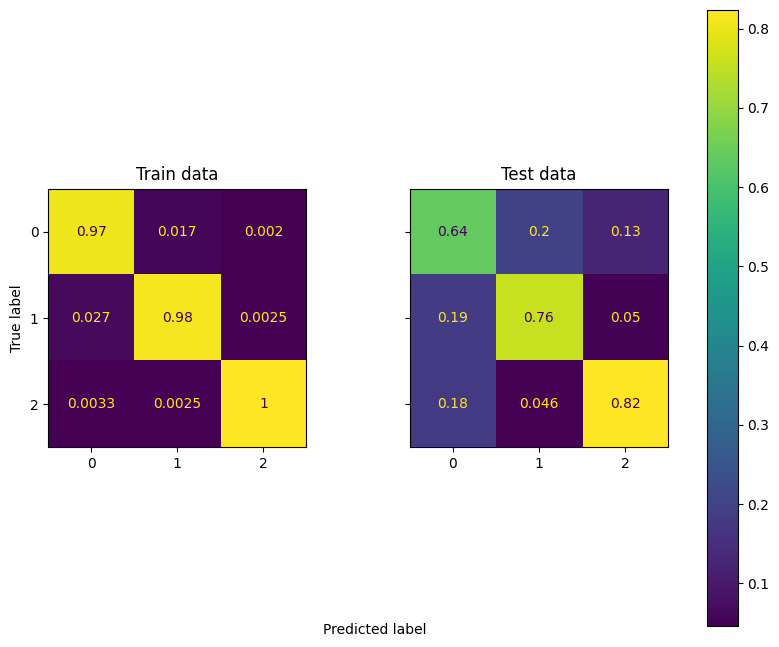

In [ ]:
from itertools import product
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
f, axarr = plt.subplots(1, 2, sharex="col", sharey="row", figsize=(10, 8))

for idx, clf, tt in zip([0,1],
    ["Train data", "Test data"],
    [trainloader,testloader] ):
    y_pred,y_test=predict(tt,model)
    result = confusion_matrix(y_test, y_pred , normalize='pred' )
    disp = ConfusionMatrixDisplay(confusion_matrix=result)
    disp.plot(ax= axarr[idx])
    disp.ax_.set_title(clf)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if idx!=0:
        disp.ax_.set_ylabel('')

f.text(0.4, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)
f.colorbar(disp.im_, ax=axarr)
plt.show()

In [ ]:
from sklearn.metrics import classification_report
all_targets, all_predictions=predict(testloader,model)
print("The model classification report on test data is as followed:")
print(classification_report(all_targets, all_predictions))

all_targets, all_predictions=predict(trainloader,model)
print("The model classification report on train data is as followed:")
print(classification_report(all_targets, all_predictions))

val:   0%|          | 0/49 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


The model classification report on test data is as followed:
              precision    recall  f1-score   support

           0       0.67      0.64      0.66       540
           1       0.76      0.76      0.76       520
           2       0.78      0.82      0.80       504

    accuracy                           0.74      1564
   macro avg       0.74      0.74      0.74      1564
weighted avg       0.74      0.74      0.74      1564



val:   0%|          | 0/228 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


The model classification report on train data is as followed:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      2417
           1       0.97      0.98      0.98      2404
           2       0.99      1.00      0.99      2445

    accuracy                           0.98      7266
   macro avg       0.98      0.98      0.98      7266
weighted avg       0.98      0.98      0.98      7266



# Task 3

In [ ]:
models=[]
histories=[]
for i in range(1,12):
  batch_size = 64
  epochs = 5
  learning_rate = 0.0001
  gamma=0.5
  step_size=10
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  config_layer = AutoConfig.from_pretrained("HooshvareLab/bert-base-parsbert-uncased",num_hidden_layers= i)
  classifier=Finetuned_bert(768,3,config_layer,False)
  model,history = train(train_loader=trainloader,val_loader=valloader,model = classifier,epochs=epochs,
                  learning_rate=learning_rate,gamma = gamma,step_size = step_size,device=device)
  models.append(model)
  histories.append(history)

Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertModel: ['bert.encoder.layer.9.attention.self.value.bias', 'bert.encoder.layer.5.attention.self.value.bias', 'bert.encoder.layer.9.attention.self.key.bias', 'bert.encoder.layer.10.attention.output.dense.bias', 'bert.encoder.layer.10.output.dense.weight', 'bert.encoder.layer.1.output.dense.bias', 'bert.encoder.layer.8.output.LayerNorm.weight', 'bert.encoder.layer.10.attention.output.dense.weight', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.self.key.weight', 'bert.encoder.layer.6.attention.output.dense.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.intermediate.dense.weight', 'bert.encoder.layer.1.attention.self.query.weight', 'bert.encoder.layer.5.attention.output.dense.bias', 'bert.encoder.layer.3.attention.self.value.bias', 'bert.encoder.layer.10.attention.self.query.bias', 'bert.encoder.layer.2.

  0%|          | 0/5 [00:00<?, ?it/s]

train:   0%|          | 0/1 [00:00<?, ?it/s]

val:   0%|          | 0/49 [00:00<?, ?it/s]

train:   0%|          | 0/1 [00:00<?, ?it/s]

val:   0%|          | 0/49 [00:00<?, ?it/s]

train:   0%|          | 0/1 [00:00<?, ?it/s]

val:   0%|          | 0/49 [00:00<?, ?it/s]

train:   0%|          | 0/1 [00:00<?, ?it/s]

val:   0%|          | 0/49 [00:00<?, ?it/s]

train:   0%|          | 0/1 [00:00<?, ?it/s]

val:   0%|          | 0/49 [00:00<?, ?it/s]

val:   0%|          | 0/49 [00:00<?, ?it/s]

val:   0%|          | 0/1 [00:00<?, ?it/s]

Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertModel: ['bert.encoder.layer.9.attention.self.value.bias', 'bert.encoder.layer.5.attention.self.value.bias', 'bert.encoder.layer.9.attention.self.key.bias', 'bert.encoder.layer.10.attention.output.dense.bias', 'bert.encoder.layer.10.output.dense.weight', 'bert.encoder.layer.1.output.dense.bias', 'bert.encoder.layer.8.output.LayerNorm.weight', 'bert.encoder.layer.10.attention.output.dense.weight', 'bert.encoder.layer.6.attention.output.dense.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.intermediate.dense.weight', 'bert.encoder.layer.1.attention.self.query.weight', 'bert.encoder.layer.5.attention.output.dense.bias', 'bert.encoder.layer.3.attention.self.value.bias', 'bert.encoder.layer.10.attention.self.query.bias', 'bert.encoder.layer.2.intermediate.dense.bias', 'bert.encoder.layer.5.intermediate.dense.bias', 'bert.encoder.layer.7.at

  0%|          | 0/5 [00:00<?, ?it/s]

train:   0%|          | 0/1 [00:00<?, ?it/s]

val:   0%|          | 0/49 [00:00<?, ?it/s]

train:   0%|          | 0/1 [00:00<?, ?it/s]

val:   0%|          | 0/49 [00:00<?, ?it/s]

train:   0%|          | 0/1 [00:00<?, ?it/s]

val:   0%|          | 0/49 [00:00<?, ?it/s]

train:   0%|          | 0/1 [00:00<?, ?it/s]

val:   0%|          | 0/49 [00:00<?, ?it/s]

train:   0%|          | 0/1 [00:00<?, ?it/s]

val:   0%|          | 0/49 [00:00<?, ?it/s]

val:   0%|          | 0/49 [00:00<?, ?it/s]

val:   0%|          | 0/1 [00:00<?, ?it/s]

Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertModel: ['bert.encoder.layer.9.attention.self.value.bias', 'bert.encoder.layer.5.attention.self.value.bias', 'bert.encoder.layer.9.attention.self.key.bias', 'bert.encoder.layer.10.attention.output.dense.bias', 'bert.encoder.layer.10.output.dense.weight', 'bert.encoder.layer.8.output.LayerNorm.weight', 'bert.encoder.layer.10.attention.output.dense.weight', 'bert.encoder.layer.6.attention.output.dense.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.5.attention.output.dense.bias', 'bert.encoder.layer.3.attention.self.value.bias', 'bert.encoder.layer.10.attention.self.query.bias', 'bert.encoder.layer.2.intermediate.dense.bias', 'bert.encoder.layer.5.intermediate.dense.bias', 'bert.encoder.layer.7.attention.self.key.bias', 'bert.encoder.layer.11.intermediate.dense.weight', 'bert.encoder.layer.7.intermediate.dense.bias', 'bert.encoder.layer.2

  0%|          | 0/5 [00:00<?, ?it/s]

train:   0%|          | 0/1 [00:00<?, ?it/s]

val:   0%|          | 0/49 [00:00<?, ?it/s]

train:   0%|          | 0/1 [00:00<?, ?it/s]

val:   0%|          | 0/49 [00:00<?, ?it/s]

train:   0%|          | 0/1 [00:00<?, ?it/s]

val:   0%|          | 0/49 [00:00<?, ?it/s]

train:   0%|          | 0/1 [00:00<?, ?it/s]

val:   0%|          | 0/49 [00:00<?, ?it/s]

In [ ]:
y_preds_test=[]
y_tests_test= [] 
y_preds_train=[]
y_tests_train= [] 

histories=[]
for i in range(0,12):
  batch_size = 64
  epochs = 5
  learning_rate = 0.0001
  gamma=0.5
  step_size=10
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  config_layer = AutoConfig.from_pretrained("HooshvareLab/bert-base-parsbert-uncased",num_hidden_layers= i)
  classifier=Finetuned_bert(768,3,config_layer,False)
  model,history = train(train_loader=trainloader,val_loader=valloader,model = classifier,epochs=epochs,
                  learning_rate=learning_rate,gamma = gamma,step_size = step_size,device=device)
  pred ,label= predict(testloader, model)
  y_preds_test.append(pred)
  y_tests_test.append(label)
  pred ,label= predict(trainloader, model)
  y_preds_train.append(pred)
  y_tests_train.append(label)
  histories.append(history)

val:   0%|          | 0/1 [00:00<?, ?it/s]

Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertModel: ['bert.encoder.layer.6.attention.output.LayerNorm.weight', 'bert.encoder.layer.6.output.dense.bias', 'bert.encoder.layer.8.attention.output.dense.weight', 'bert.encoder.layer.11.intermediate.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'bert.encoder.layer.8.attention.output.LayerNorm.weight', 'bert.encoder.layer.9.attention.output.dense.bias', 'cls.seq_relationship.weight', 'bert.encoder.layer.9.output.LayerNorm.weight', 'cls.seq_relationship.bias', 'bert.encoder.layer.11.attention.output.LayerNorm.bias', 'bert.encoder.layer.9.attention.self.query.bias', 'bert.encoder.layer.7.output.LayerNorm.bias', 'cls.predictions.bias', 'bert.encoder.layer.9.attention.self.key.weight', 'bert.encoder.layer.8.attention.output.LayerNorm.bias', 'bert.encoder.layer.9.attention.self.value.bias', 'cls.pre

#######################
0
#######################


val:   0%|          | 0/228 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


val:   0%|          | 0/49 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


#######################
1
#######################


val:   0%|          | 0/228 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


val:   0%|          | 0/49 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


#######################
2
#######################


val:   0%|          | 0/228 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


val:   0%|          | 0/49 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


#######################
3
#######################


val:   0%|          | 0/228 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


val:   0%|          | 0/49 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


#######################
4
#######################


val:   0%|          | 0/228 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


val:   0%|          | 0/49 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


#######################
5
#######################


val:   0%|          | 0/228 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


val:   0%|          | 0/49 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


#######################
6
#######################


val:   0%|          | 0/228 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


val:   0%|          | 0/49 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


#######################
7
#######################


val:   0%|          | 0/228 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


val:   0%|          | 0/49 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


#######################
8
#######################


IndexError: ignored

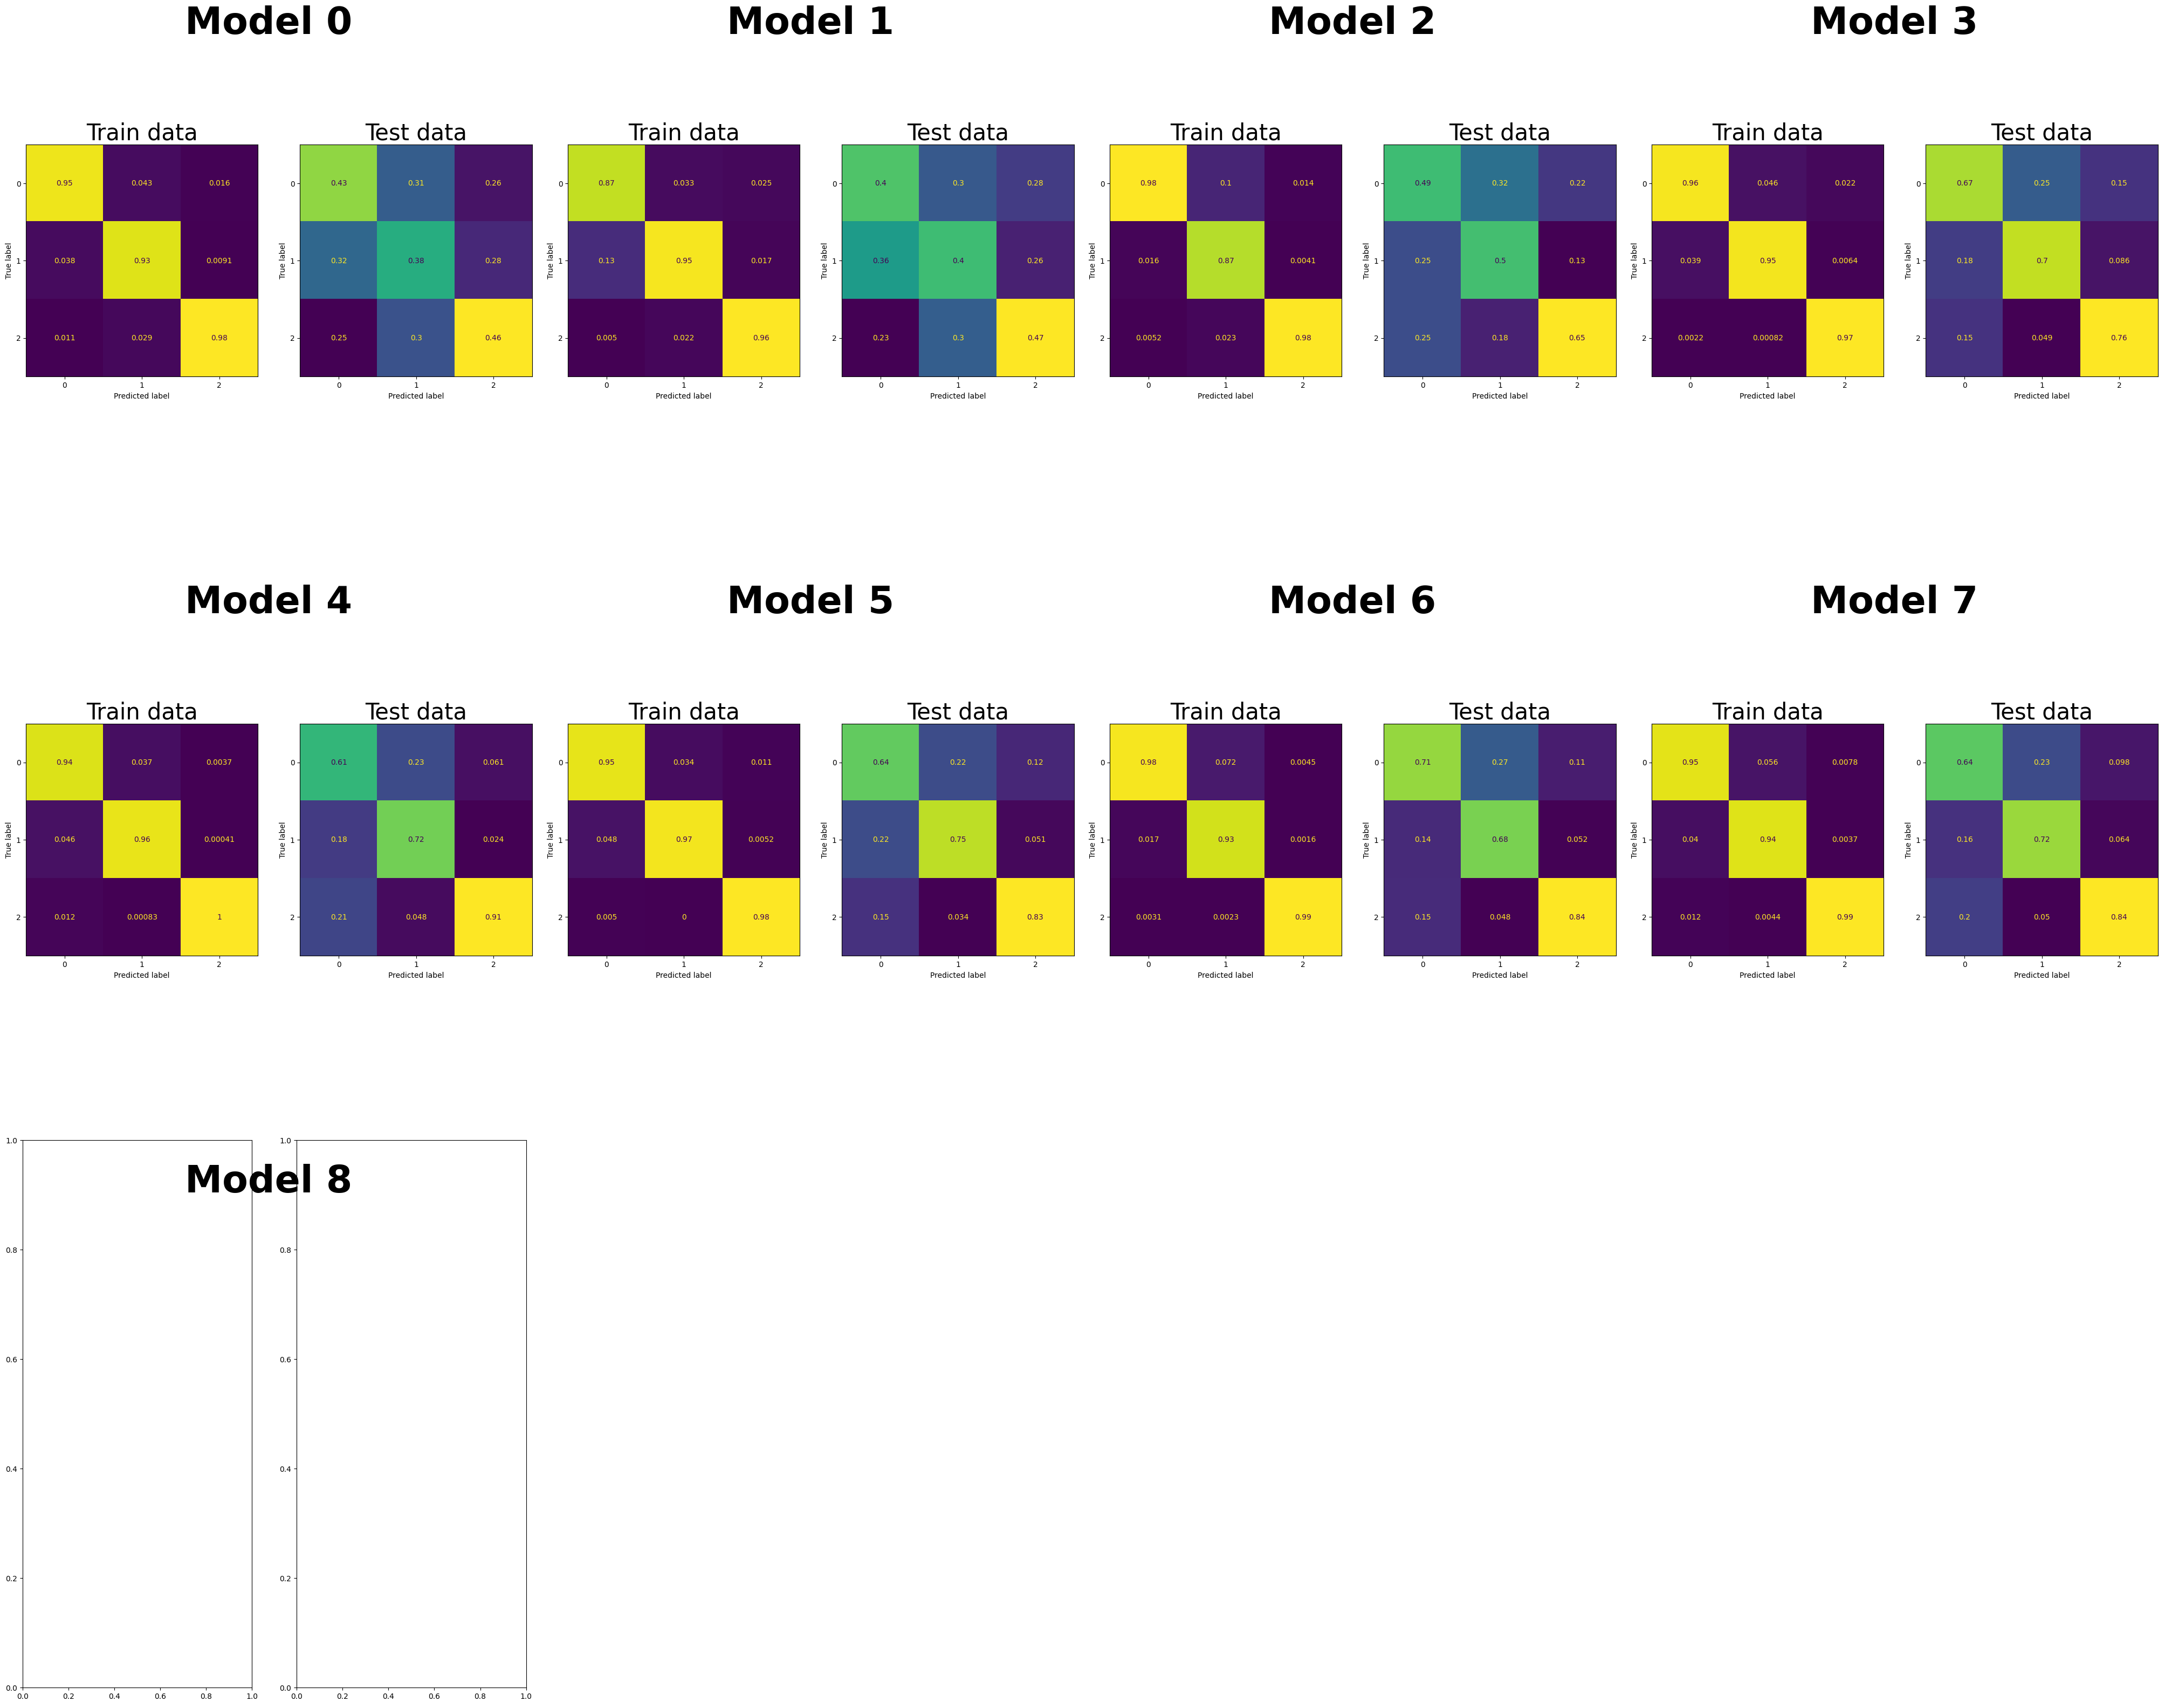

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(constrained_layout=True,figsize=(40, 32))

subfigs = fig.subfigures(3, 4)

for outerind, subfig in enumerate(subfigs.flat):
    subfig.suptitle(f'Model {outerind}', x=0.5, y=0.95, ha='center', fontsize=50, fontweight='bold')
    axs = subfig.subplots(1, 2)
    print("#######################")
    print(outerind)
    print("#######################")
    for j, ax, dataname, tt in zip(range(2),axs.flat, ["Train data", "Test data"], [trainloader, testloader]):
        y_pred, y_test = predict(tt, models[outerind])
        result = confusion_matrix(y_test, y_pred, normalize='pred')
        disp = ConfusionMatrixDisplay(confusion_matrix=result)
        ax.set_title(dataname,fontsize=30)
        disp.plot(ax=ax)
        disp.im_.colorbar.remove()
fig.colorbar(disp.im_, ax=ax) 
plt.show()

IndexError: ignored

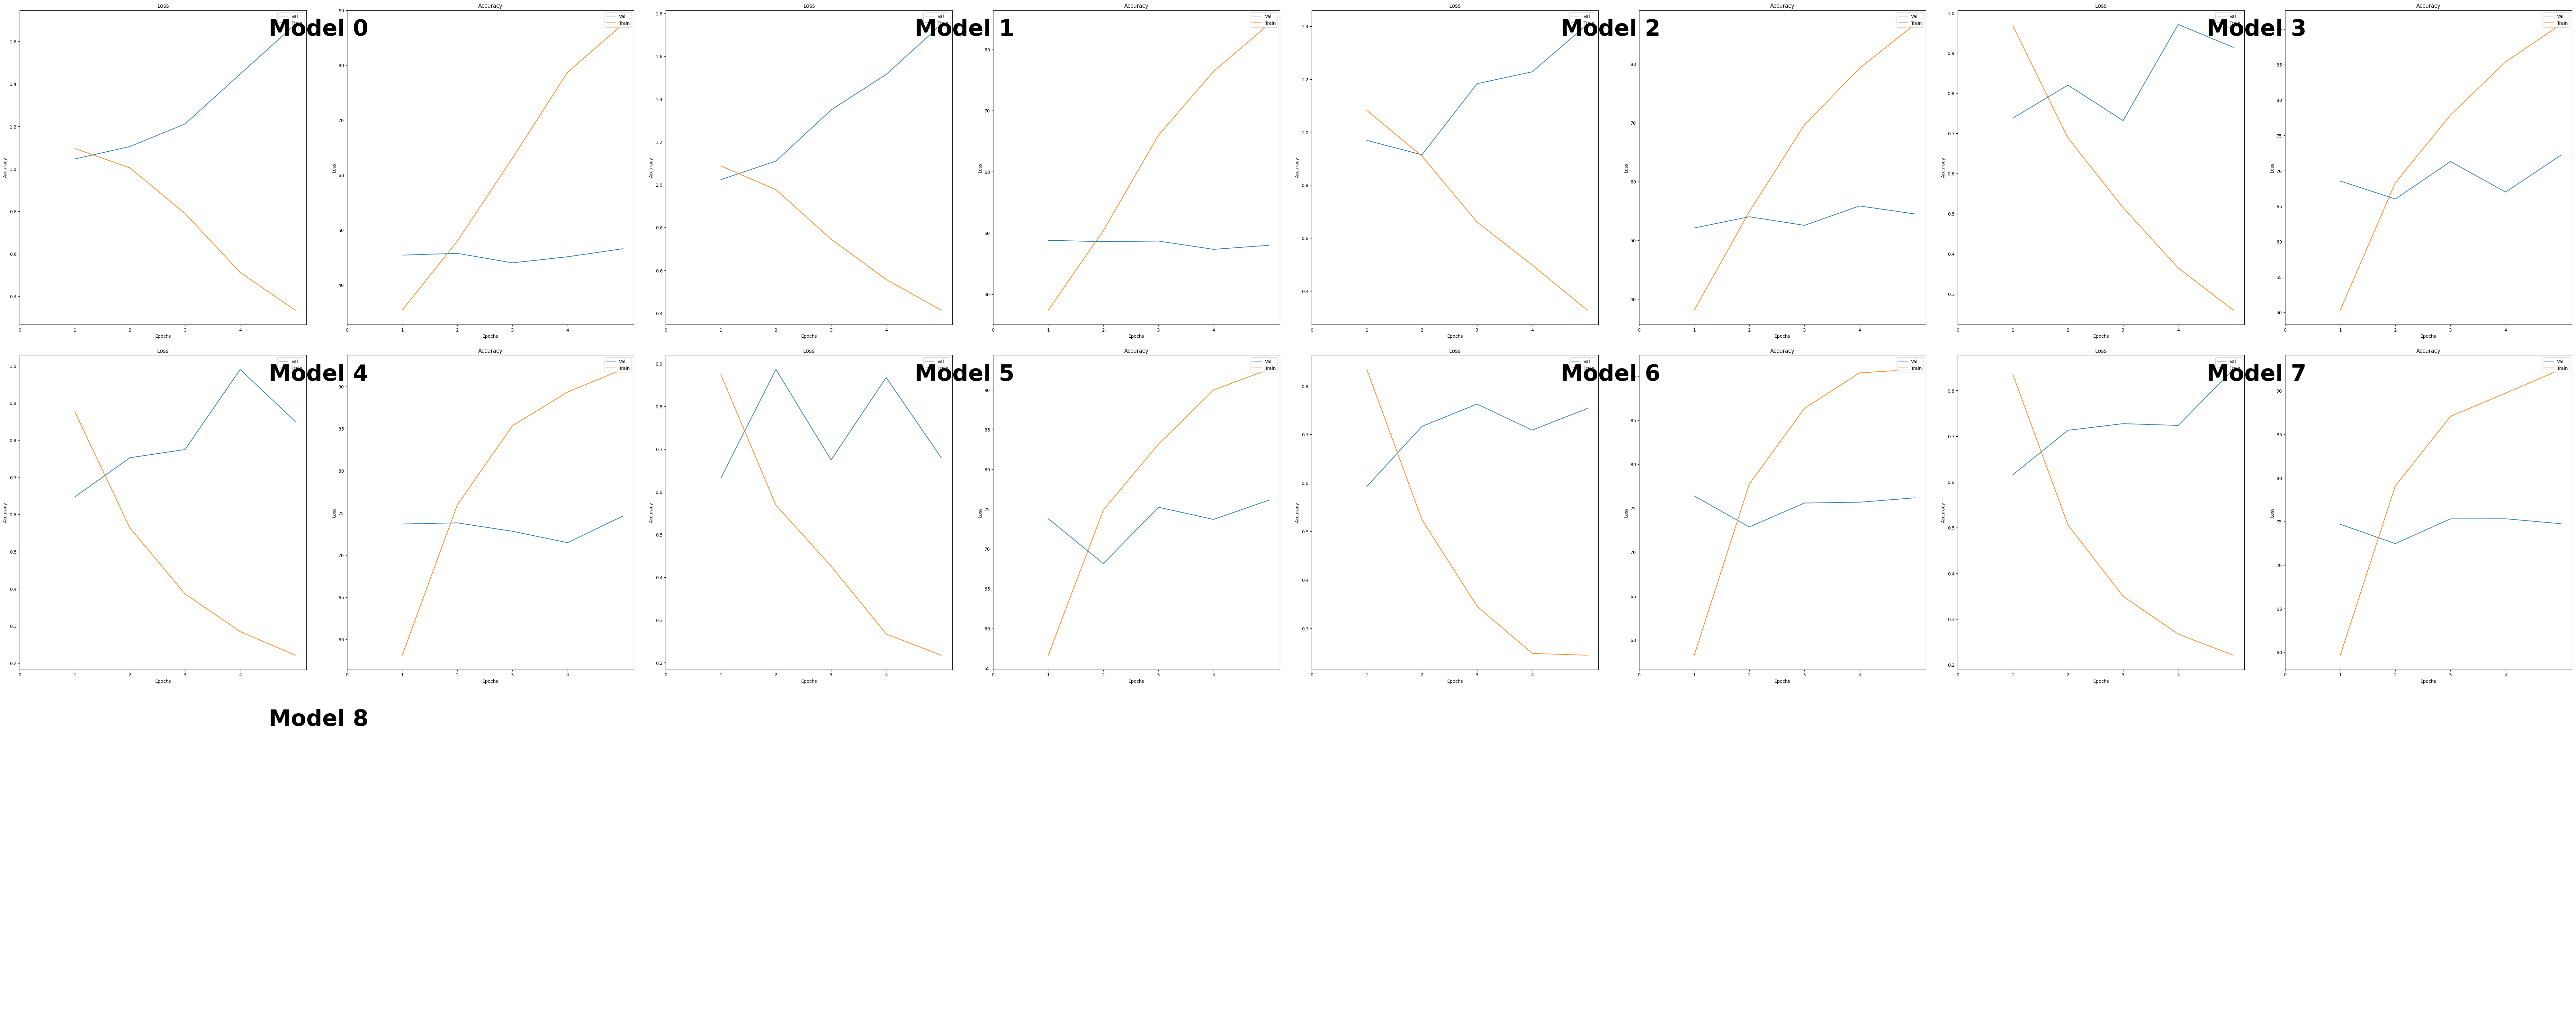

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(constrained_layout=True, figsize=(80, 32))
subfigs = fig.subfigures(3, 4)

for outerind, subfig in enumerate(subfigs.flat):
    subfig.suptitle(f'Model {outerind}', x=0.5, y=0.95, ha='center', fontsize=50, fontweight='bold')
    # Get the history data for the current model
    history = histories[outerind]
    
    # Create subplots within the subfigure
    ax1 = subfig.add_subplot(1, 2, 1)
    ax1.plot(history['epochs'], history['val_loss'])
    ax1.plot(history['epochs'], history['train_loss'])
    ax1.set_xticks(range(len(history['epochs'])))
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Accuracy")
    ax1.set_title("Loss")
    ax1.legend(["Val", "Train"], loc='upper right')

    ax2 = subfig.add_subplot(1, 2, 2)
    ax2.plot(history['epochs'], history['val_acc'])
    ax2.plot(history['epochs'], history['train_acc'])
    ax2.set_xticks(range(len(history['epochs'])))
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Loss")
    ax2.set_title("Accuracy")
    ax2.legend(["Val", "Train"], loc='upper right')

plt.show()


In [ ]:
from sklearn.metrics import accuracy_score
acc_score=[]
for model in models:
  all_targets, all_predictions=predict(testloader,model)
  acc_score.append(accuracy_score(all_targets, all_predictions))

val:   0%|          | 0/49 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


val:   0%|          | 0/49 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


val:   0%|          | 0/49 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


val:   0%|          | 0/49 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


val:   0%|          | 0/49 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


val:   0%|          | 0/49 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


val:   0%|          | 0/49 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


val:   0%|          | 0/49 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


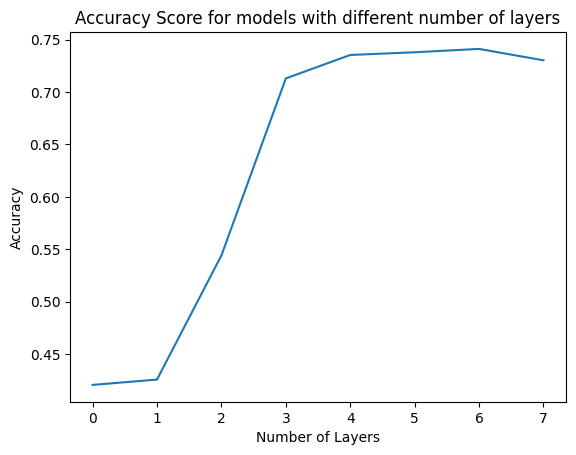

In [ ]:
plt.plot(range(8),acc_score)
plt.title("Accuracy Score for models with different number of layers")
plt.xlabel("Number of Layers")
plt.ylabel("Accuracy")
plt.show()

# Task 4

In [ ]:
class Fineed_Bert_heads(nn.Module):
    def __init__(self, hidden_size, num_classes,config_layer,freeze,drop_heads):
        super(Fineed_Bert_heads, self).__init__()
        self.model = AutoModel.from_pretrained("HooshvareLab/bert-base-parsbert-uncased",config = config_layer)
        self.model=self.model.to(device)
        if freeze:
          for param in self.model.parameters():
            param.requires_grad = False
        self.fc1 = nn.Linear(hidden_size, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, num_classes)
        self.drop_heads = drop_heads

    def forward(self,ids,mask,token_type_ids):
        self.model.prune_heads(self.drop_heads)
        _,o2= self.model(ids,attention_mask=mask,token_type_ids=token_type_ids, return_dict=False)
        o2 = self.fc1(o2)
        o2 = self.relu(o2)
        logits = self.fc2(o2)
        return logits

In [ ]:
def generate_dictionary(num_values, percent):
    random.seed(5)
    dictionary = {}
    num_chosen = int((percent / 100) * num_values)
    for key in range(0, 12):
        values = random.sample(range(num_values), num_chosen)
        dictionary[key] = values
    return dictionary

In [ ]:
probabilities=[0.50,0.67,0.83]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
models=[]
histories=[]
for p in probabilities:
  config_layer = AutoConfig.from_pretrained("HooshvareLab/bert-base-parsbert-uncased",attention_probs_dropout_prob=p)
  drop_heads = generate_dictionary(12,p)
  classifier=Fineed_Bert_heads(768,3,config_layer,False,drop_heads)
  batch_size = 64
  epochs = 5
  learning_rate = 0.0001
  gamma=0.5
  step_size=10
  model,history = train(train_loader=trainloader,val_loader=valloader,model = classifier,epochs=epochs,
                  learning_rate=learning_rate,gamma = gamma,step_size = step_size,device=device)
  models.append(model)
  histories.append(history)

Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/5 [00:00<?, ?it/s]

train:   0%|          | 0/228 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


val:   0%|          | 0/49 [00:00<?, ?it/s]

train:   0%|          | 0/228 [00:00<?, ?it/s]

val:   0%|          | 0/49 [00:00<?, ?it/s]

train:   0%|          | 0/228 [00:00<?, ?it/s]

val:   0%|          | 0/49 [00:00<?, ?it/s]

train:   0%|          | 0/228 [00:00<?, ?it/s]

val:   0%|          | 0/49 [00:00<?, ?it/s]

train:   0%|          | 0/228 [00:00<?, ?it/s]

val:   0%|          | 0/49 [00:00<?, ?it/s]

Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/5 [00:00<?, ?it/s]

train:   0%|          | 0/228 [00:00<?, ?it/s]

val:   0%|          | 0/49 [00:00<?, ?it/s]

train:   0%|          | 0/228 [00:00<?, ?it/s]

val:   0%|          | 0/49 [00:00<?, ?it/s]

train:   0%|          | 0/228 [00:00<?, ?it/s]

val:   0%|          | 0/49 [00:00<?, ?it/s]

train:   0%|          | 0/228 [00:00<?, ?it/s]

val:   0%|          | 0/49 [00:00<?, ?it/s]

train:   0%|          | 0/228 [00:00<?, ?it/s]

val:   0%|          | 0/49 [00:00<?, ?it/s]

Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/5 [00:00<?, ?it/s]

train:   0%|          | 0/228 [00:00<?, ?it/s]

val:   0%|          | 0/49 [00:00<?, ?it/s]

train:   0%|          | 0/228 [00:00<?, ?it/s]

val:   0%|          | 0/49 [00:00<?, ?it/s]

train:   0%|          | 0/228 [00:00<?, ?it/s]

val:   0%|          | 0/49 [00:00<?, ?it/s]

train:   0%|          | 0/228 [00:00<?, ?it/s]

val:   0%|          | 0/49 [00:00<?, ?it/s]

train:   0%|          | 0/228 [00:00<?, ?it/s]

val:   0%|          | 0/49 [00:00<?, ?it/s]

val:   0%|          | 0/228 [00:00<?, ?it/s]

val:   0%|          | 0/49 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


val:   0%|          | 0/228 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


val:   0%|          | 0/49 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


val:   0%|          | 0/228 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


val:   0%|          | 0/49 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


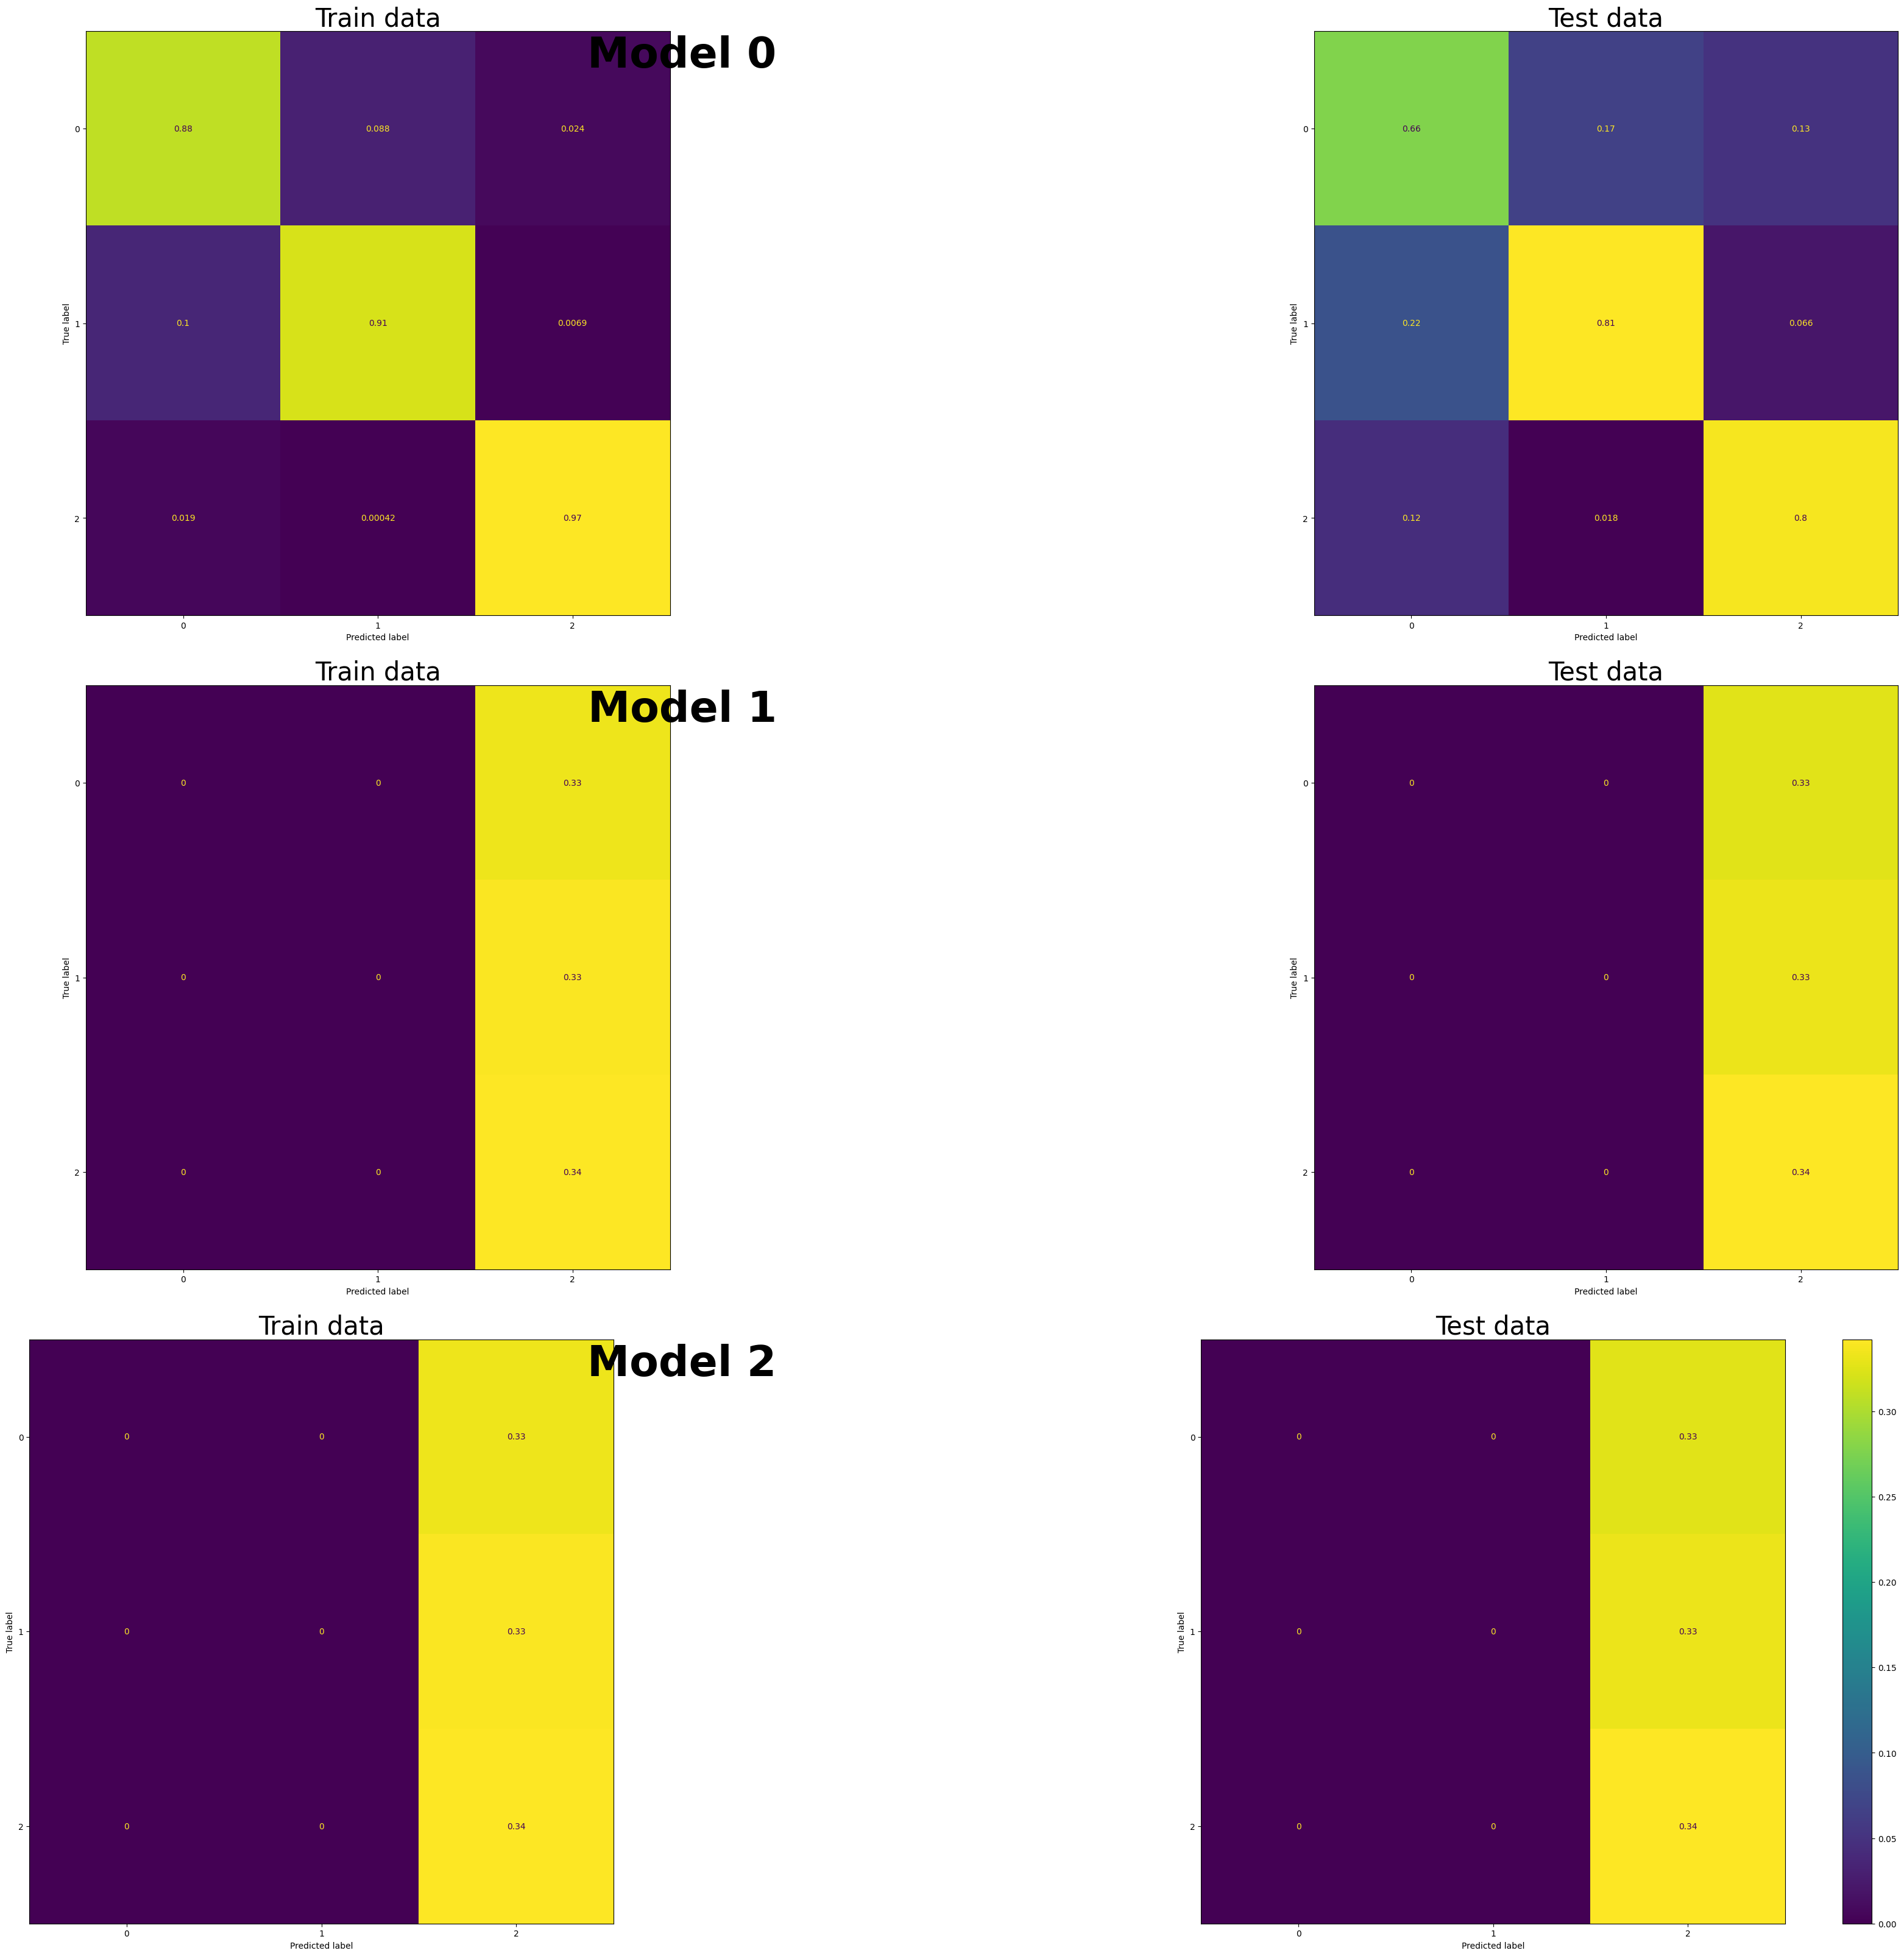

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(constrained_layout=True,figsize=(40, 32))

subfigs = fig.subfigures(3, 1)

for outerind, subfig in enumerate(subfigs.flat):
    subfig.suptitle(f'Model {outerind}', x=0.5, y=0.95, ha='center', fontsize=50, fontweight='bold')
    axs = subfig.subplots(1, 2)
    for j, ax, dataname, tt in zip(range(2),axs.flat, ["Train data", "Test data"], [trainloader, testloader]):
        y_pred, y_test = predict(tt, models[outerind])
        result = confusion_matrix(y_test, y_pred, normalize='pred')
        disp = ConfusionMatrixDisplay(confusion_matrix=result)
        ax.set_title(dataname,fontsize=30)
        disp.plot(ax=ax)
        disp.im_.colorbar.remove()
fig.colorbar(disp.im_, ax=ax) 
plt.show()

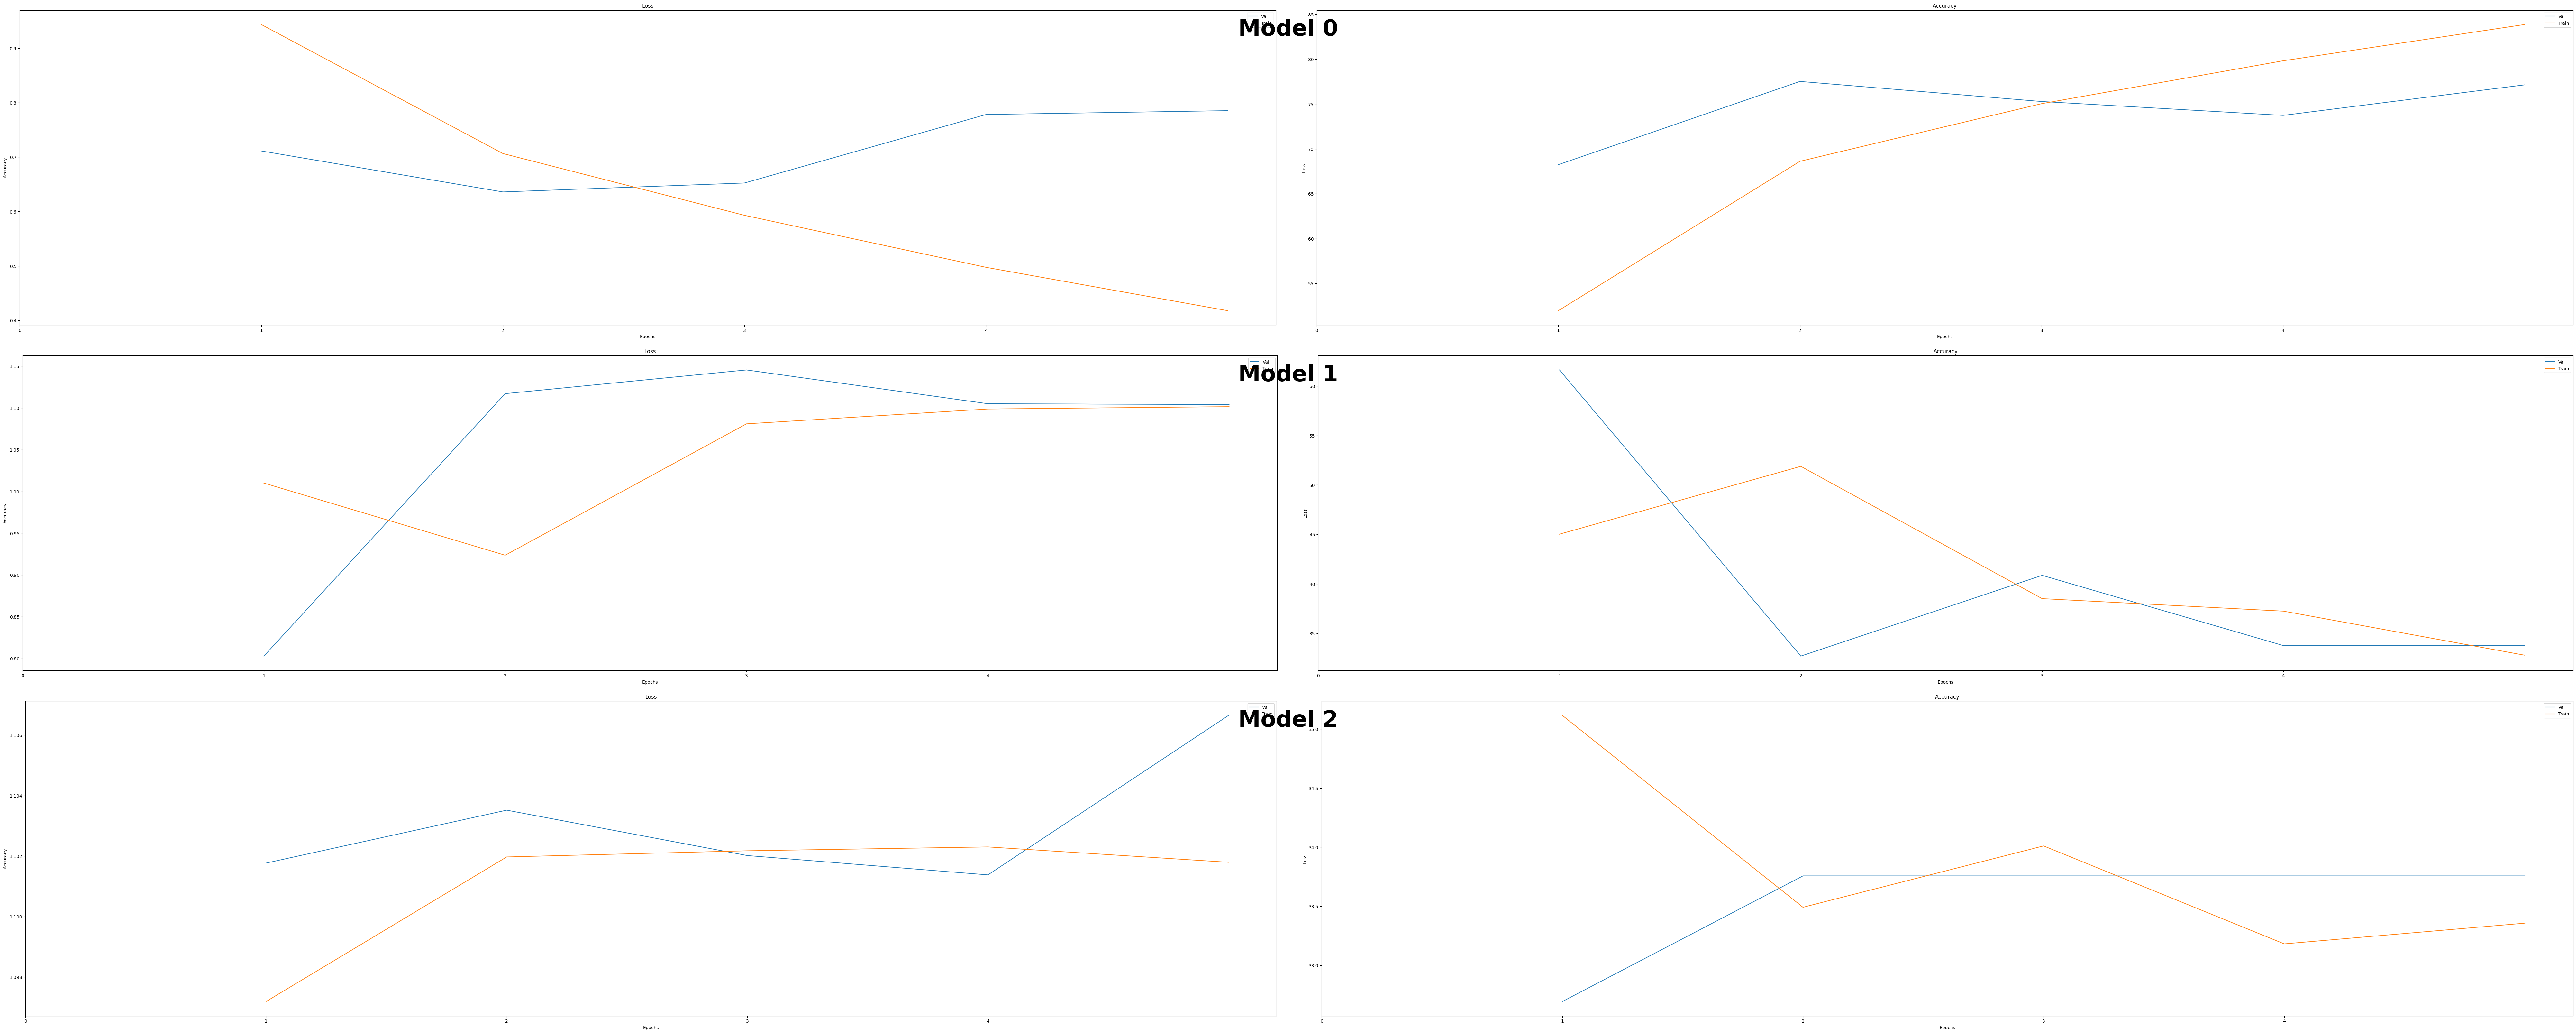

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(constrained_layout=True, figsize=(80, 32))
subfigs = fig.subfigures(3, 1)

for outerind, subfig in enumerate(subfigs.flat):
    subfig.suptitle(f'Model {outerind}', x=0.5, y=0.95, ha='center', fontsize=50, fontweight='bold')
    # Get the history data for the current model
    history = histories[outerind]
    
    # Create subplots within the subfigure
    ax1 = subfig.add_subplot(1, 2, 1)
    ax1.plot(history['epochs'], history['val_loss'])
    ax1.plot(history['epochs'], history['train_loss'])
    ax1.set_xticks(range(len(history['epochs'])))
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Accuracy")
    ax1.set_title("Loss")
    ax1.legend(["Val", "Train"], loc='upper right')

    ax2 = subfig.add_subplot(1, 2, 2)
    ax2.plot(history['epochs'], history['val_acc'])
    ax2.plot(history['epochs'], history['train_acc'])
    ax2.set_xticks(range(len(history['epochs'])))
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Loss")
    ax2.set_title("Accuracy")
    ax2.legend(["Val", "Train"], loc='upper right')

plt.show()


In [ ]:
from sklearn.metrics import accuracy_score
acc_score=[]
for model in models:
  all_targets, all_predictions=predict(testloader,model)
  acc_score.append(accuracy_score(all_targets, all_predictions))

val:   0%|          | 0/49 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


val:   0%|          | 0/49 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


val:   0%|          | 0/49 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


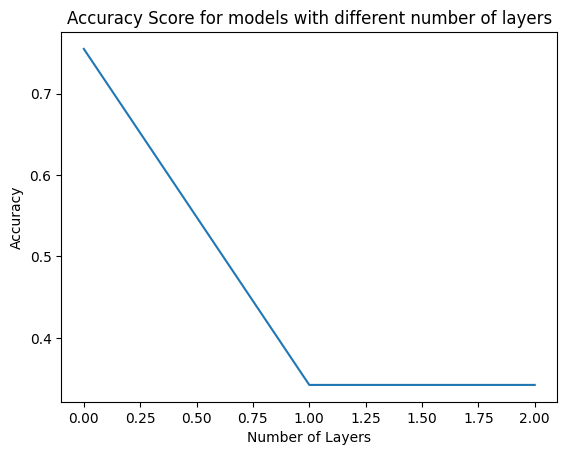

In [ ]:
plt.plot(range(3),acc_score)
plt.title("Accuracy Score for models with different number of layers")
plt.xlabel("Number of Layers")
plt.ylabel("Accuracy")
plt.show()

# Task 5

In [12]:
batch_size = 64
epochs = 3
learning_rate = 0.0001
gamma=0.5
step_size=10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config_layer = AutoConfig.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")
classifier=Finetuned_bert(768,3,config_layer,False)
model,history = train(train_loader=trainloader,val_loader=valloader,model = classifier,epochs=epochs,
                learning_rate=learning_rate,gamma = gamma,step_size = step_size,device=device)

Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/3 [00:00<?, ?it/s]

train:   0%|          | 0/228 [00:00<?, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


val:   0%|          | 0/49 [00:00<?, ?it/s]

train:   0%|          | 0/228 [00:00<?, ?it/s]

val:   0%|          | 0/49 [00:00<?, ?it/s]

train:   0%|          | 0/228 [00:00<?, ?it/s]

val:   0%|          | 0/49 [00:00<?, ?it/s]

In [14]:
data = {
    'text1': ['کار پزشک خانم خیلی خوب است', 'او باید خوب باشد','من و دوستم غذا خوریدم','او به سر کار می‌رود'],
    'text2': ['کار پرستار اقا خیلی خوب است', 'او تنها شخص خوب است', 'من با دوستم گرسنه ما‌ندیم','او کار می‌کند'],
    'label': ['n', 'n','c','e']
}
# n=2 ,c=0,e=1
# Create DataFrame
df = pd.DataFrame(data)
df.to_csv('your_file_name.csv', sep='\t', index=False)
traindataset = BertDataset(tokenizer, max_length=100,address='your_file_name.csv')
trainloader =DataLoader(dataset=traindataset,batch_size=4)

In [15]:
predication,labels=predict(trainloader,model)

val:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [16]:
predication

[0, 0, 2, 0]